In [1]:
import torch
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
import mlp
import importlib
from sklearn.model_selection import train_test_split
import sklearn
from matplotlib import pyplot as plt

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
x_train = np.loadtxt('preprocessed/x_train.csv', delimiter=',')
y_train = np.loadtxt('preprocessed/y_train.csv', delimiter=',')
x_test = np.loadtxt('preprocessed/x_test.csv', delimiter=',')
y_test = np.loadtxt('preprocessed/y_test.csv', delimiter=',')

In [4]:
x_train = torch.from_numpy(x_train).float().cuda()
y_train = torch.from_numpy(y_train).float().cuda().unsqueeze(1)
x_test = torch.from_numpy(x_test).float().cuda()
y_test = torch.from_numpy(y_test).float().cuda().unsqueeze(1)

In [5]:
size_feature = x_train.shape[1]
size_train = x_train.shape[0]
size_test = x_test.shape[0]
print(f'feature size: {size_feature} | train size: {size_train} | test size: {size_test}')

feature size: 44 | train size: 135440 | test size: 33860


In [69]:
def train(model, x_train, y_train, x_valid, y_valid, config):
    loader_train = DataLoader(list(zip(x_train, y_train)), shuffle=True, batch_size=config['batch_size'])
    optimizer = torch.optim.Adam(model.parameters(), lr=config['lr'], weight_decay=config['decay'])
    criterion = torch.nn.BCEWithLogitsLoss()

    loss_record_train = []
    loss_record_valid = []

    for epoch in range(config['num_epoch']):
        model.train()
        for i, (x, y) in enumerate(loader_train):
            out = model(x)
            loss = criterion(out, y)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        model.eval()
        out_train = model(x_train)
        loss_train = criterion(out_train, y_train).detach().item()
        loss_record_train.append(loss_train)
        yhat_train = torch.round(torch.sigmoid(out_train)).detach()
        acurracy_train = sklearn.metrics.accuracy_score(y_train.cpu().numpy(), yhat_train.cpu().numpy())

        out_valid = model(x_valid)
        loss_valid = criterion(out_valid, y_valid).detach().item()
        loss_record_valid.append(loss_valid)
        yhat_valid = torch.round(torch.sigmoid(out_valid)).detach()
        acurracy_valid = sklearn.metrics.accuracy_score(y_valid.cpu().numpy(), yhat_valid.cpu().numpy())

        print(f'\r[Info] epoch: {epoch + 1}/{config["num_epoch"]} | training loss: {loss_train} | training accuracy: {acurracy_train} | validation loss: {loss_valid} | validation accuracy: {acurracy_valid}', end='')
    print('\n[Info] Done')
    return loss_record_train, loss_record_valid

def cross_validation(x_train, y_train, config, K=5):
    kf = sklearn.model_selection.KFold(n_splits=K)
    kf.get_n_splits(x_train)
    mean_loss_valid = 0.0
    fig = plt.gcf()
    fig.set_size_inches(5 * K, 5)
    for i, (idx_train, idx_valid) in enumerate(kf.split(x_train)):
        print(f'[Info] fold: {(i + 1)}/{K}')
        model = mlp.MLP(config['size_feature'], 1, config['hidden_layers'], config['act'])
        loss_record_train, loss_record_valid = train(model, x_train[idx_train], y_train[idx_train], x_train[idx_valid], y_train[idx_valid], config)
        plt.subplot(1, K, i + 1)
        plt.plot(loss_record_train, label='training')
        plt.plot(loss_record_valid, label='validation')
        plt.legend()
        mean_loss_valid += loss_record_valid[-1]
    
    mean_loss_valid /= K
    plt.show()
    return mean_loss_valid

## Explore different hidden layers configuration

In [73]:
config = dict(
    size_feature = size_feature,
    act = 'tanh',
    batch_size = 512,
    num_epoch = 50,
    lr = 1e-3,
    decay = 1e-6,
)

[Info] fold: 1/5
[Info] epoch: 50/50 | training loss: 0.3928307890892029 | training accuracy: 0.8152595245126993 | validation loss: 0.4001544415950775 | validation accuracy: 0.8124630832841111
[Info] Done
[Info] fold: 2/5
[Info] epoch: 50/50 | training loss: 0.39100950956344604 | training accuracy: 0.8156286916715889 | validation loss: 0.4055960774421692 | validation accuracy: 0.810063496751329
[Info] Done
[Info] fold: 3/5
[Info] epoch: 50/50 | training loss: 0.39516451954841614 | training accuracy: 0.8128968546958063 | validation loss: 0.4047568440437317 | validation accuracy: 0.810875664500886
[Info] Done
[Info] fold: 4/5
[Info] epoch: 50/50 | training loss: 0.39211228489875793 | training accuracy: 0.8151949202598937 | validation loss: 0.4087598919868469 | validation accuracy: 0.8037138216184289
[Info] Done
[Info] fold: 5/5
[Info] epoch: 50/50 | training loss: 0.3905394971370697 | training accuracy: 0.8148903573538098 | validation loss: 0.40987586975097656 | validation accuracy: 0.80

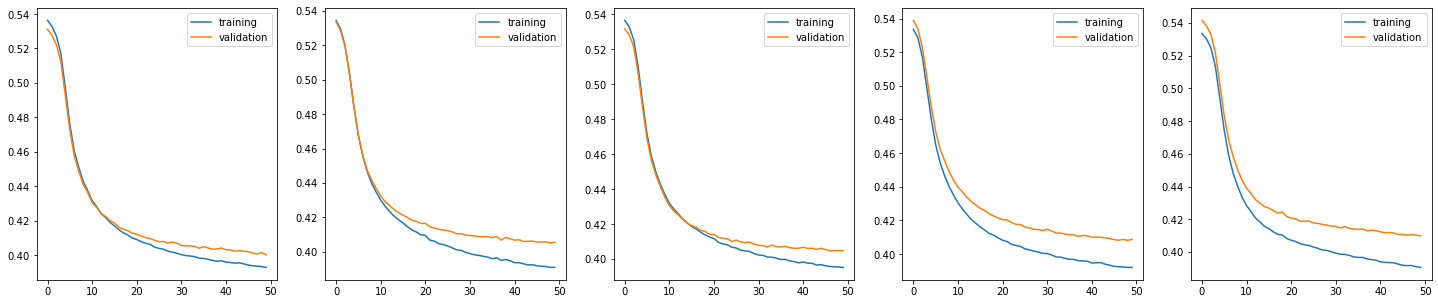

[Info] average validation loss: 0.4058286249637604


In [75]:
config['hidden_layers'] = [32]
mean_loss_valid = cross_validation(x_train, y_train, config)
print(f'[Info] average validation loss: {mean_loss_valid}')

## Evaluate the best model on test data

[Info] epoch: 50/50 | training loss: 0.39374715089797974 | training accuracy: 0.8121677495569994 | validation loss: 0.4037639796733856 | validation accuracy: 0.8079740106320141
[Info] Done


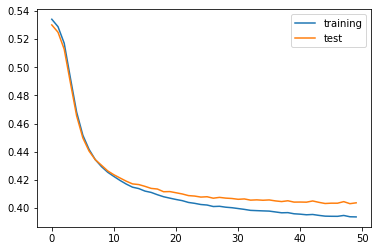

In [76]:
best_config = dict(
    size_feature = size_feature,
    act = 'tanh',
    hidden_layers = [32],
    batch_size = 512,
    num_epoch = 50,
    lr = 1e-3,
    decay = 1e-6,
)
best_model = mlp.MLP(best_config['size_feature'], 1, best_config['hidden_layers'], best_config['act'])
loss_record_train, loss_record_valid = train(best_model, x_train, y_train, x_test, y_test, config)
plt.plot(loss_record_train, label='training')
plt.plot(loss_record_valid, label='test')
plt.legend()
plt.show()

In [77]:
best_model.eval()
yhat_test = torch.round(torch.sigmoid(best_model(x_test)))
yhat_test_ = yhat_test.detach().cpu().numpy()
y_test_ = y_test.cpu().numpy()
print(sklearn.metrics.classification_report(y_test_, yhat_test_))

              precision    recall  f1-score   support

         0.0       0.79      0.83      0.81     16863
         1.0       0.82      0.79      0.80     16997

    accuracy                           0.81     33860
   macro avg       0.81      0.81      0.81     33860
weighted avg       0.81      0.81      0.81     33860



In [80]:
print(f'roc auc score: {sklearn.metrics.roc_auc_score(y_test_, yhat_test_)}')

roc auc score: 0.808060766474862


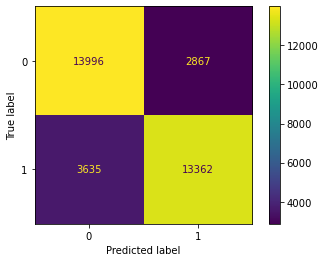

In [81]:
cm = sklearn.metrics.confusion_matrix(y_test_, yhat_test_)
cm_disp = sklearn.metrics.ConfusionMatrixDisplay(cm)
cm_disp.plot()
plt.show()